In [1]:
%matplotlib inline
import ast
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import webcolors
from collections import defaultdict
from matplotlib import patheffects
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import PercentFormatter, FormatStrFormatter
from PIL import Image, ImageOps
plt.rcParams["figure.figsize"] = (20,7)
fontsize = 20
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize

In [42]:
mention_df_raw = pd.read_csv("../mention-extraction/figures_mentions.csv", index_col=0)
classification_df = pd.read_csv("../classify-figures/classifications/try3.csv", index_col=0)
properties_df = pd.read_csv("../figure-properties-extraction/img_properties.csv", index_col=0)

In [3]:
# colors
blue = "#4477AA"
pink = "#EE6677"
green = "#228833"
dirtyellow = "#CCBB44"
lightblue = "#66CCEE"
purple = "#AA3377"
grey = "#BBBBBB"
orange = "#EE7733"
green2 = "#009988"
yellow = "#DDAA33"
red = "#CC3311"
darkblue = "#004488"
colors = [blue, pink, green, dirtyellow, lightblue, purple, grey, orange, green2, yellow, red, darkblue]


# Dataset

In [4]:
conf_count = 0
total_pdf_count = 0
conf_dict = {}
for conf in os.listdir("../data-collection/pdfs-cleanup/"):
    pdf_count = 0
    conf_abbr = conf.split("-")[1].strip("2024").upper()
    conf_count += 1
    for file in os.listdir(f"../data-collection/pdfs-cleanup/{conf}"):
        pdf_count += 1
        total_pdf_count += 1
    conf_dict[conf_abbr] = pdf_count
fig_count = len(classification_df[['doi', 'fig_num']].drop_duplicates())
data_fig_count = len(classification_df[classification_df['type']=='D'][['doi', 'fig_num']].drop_duplicates())
data_vis_count = len(classification_df[classification_df['type']=='D'])
vis_count_total = len(classification_df)
        
print(f"{'Conferences:':<19}{conf_count}")
print(f"{'Papers:':<19}{total_pdf_count}")
print(f"{'Figures:':<19}{fig_count}")
print(f"{'Data Vis. Figures:':<19}{data_fig_count}")
print(f"{'Data Visualisations:':<19}{data_vis_count}")
print(f"{'Visualisations (process + data):':<19}{vis_count_total}")

print()
for conf_abbr in sorted(conf_dict.keys()):
    print(f"{conf_abbr:<7}{conf_dict[conf_abbr]} Papers")
    

Conferences:       17
Papers:            1046
Figures:           5798
Data Vis. Figures: 2070
Data Visualisations:4293
Visualisations (process + data):8023

ASE    155 Papers
EASE   32 Papers
ECSA   24 Papers
ESEM   34 Papers
FSE    121 Papers
ICPC   30 Papers
ICSA   10 Papers
ICSE   234 Papers
ICSME  49 Papers
ICST   28 Papers
ISSRE  21 Papers
ISSTA  143 Papers
MODELS 26 Papers
MSR    41 Papers
RE     17 Papers
SANER  61 Papers
SEAMS  20 Papers


# Figure type

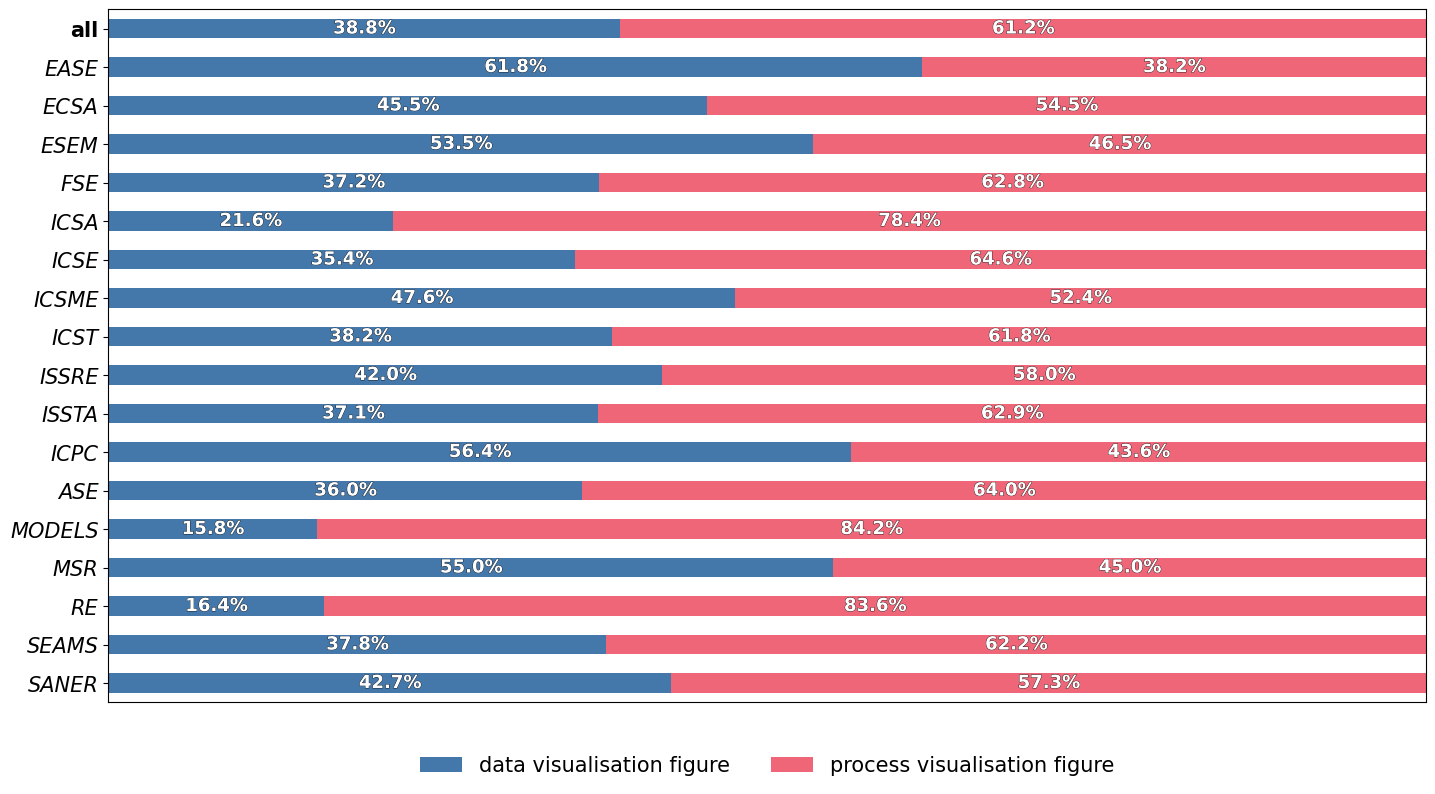

In [5]:
df_type_perc = classification_df[(classification_df["type"] != "INVALID") & (classification_df["type"] != "T")].drop_duplicates(subset=['doi', 'fig_num']).groupby(["conf", "type"]).size().unstack(fill_value=0)
df_type_perc.loc["all"] = df_type_perc.sum()
df_type_perc = df_type_perc.div(df_type_perc.sum(axis=1), axis=0).mul(100).sort_index(ascending=False)#.round(1)#.reset_index()
df_type_perc.index = df_type_perc.index.map(lambda x: x.split("-")[1].strip("2024").upper() if not x=="all" else x)

ax = df_type_perc.plot(kind="barh", figsize=(17,9), stacked=True, xticks=[], fontsize=10, color=colors, ylabel="")
ax.set_xlim((0,100))
ax.legend(labels=["data visualisation figure", "process visualisation figure", "table"], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False, fontsize=15)
ax.set_xmargin(0.01)

for label in ax.get_yticklabels():
    if label.get_text() == "all":
        label.set_fontweight("bold")
    else:
        label.set_style("italic")
    label.set_fontsize(15)

for c in ax.containers:
    labels = [f'{w:0.1f}%' if (w := v.get_width()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', padding=0.3, color='white', fontsize=13, fontweight="bold",
                 path_effects=[patheffects.withStroke(linewidth=0.5, foreground='black')])


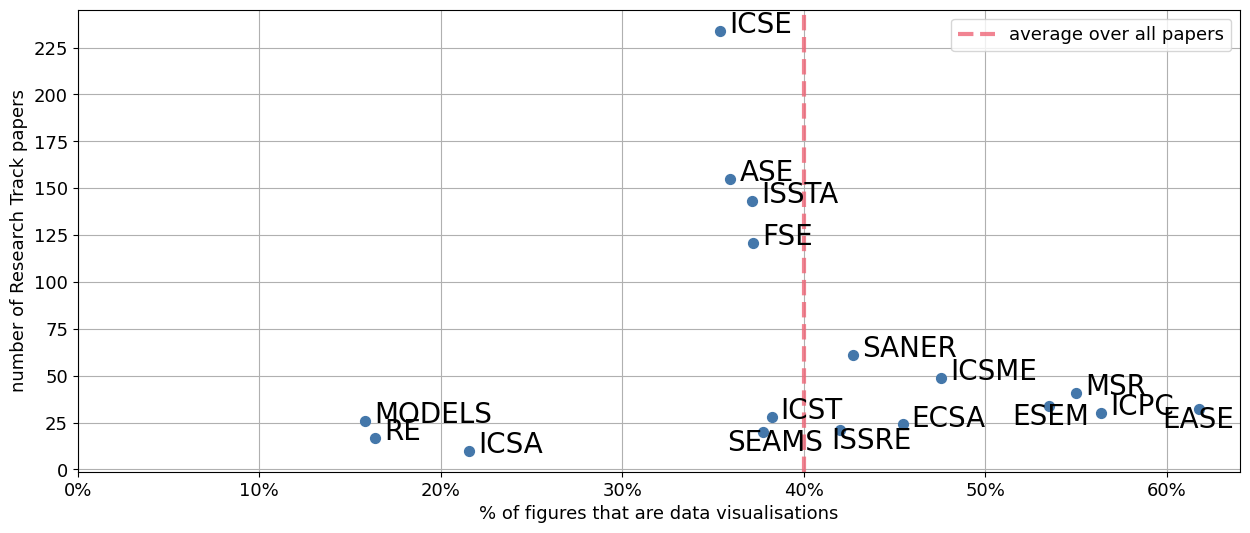

In [6]:
df_type_perc = classification_df[(classification_df["type"] != "INVALID") & (classification_df["type"] != "T")].drop_duplicates(subset=['doi', 'fig_num']).groupby(["conf", "type"]).size().unstack(fill_value=0)
# df_type_perc.loc["all"] = df_type_perc.sum()
df_type_perc = df_type_perc.div(df_type_perc.sum(axis=1), axis=0).mul(100).sort_index(ascending=False)#.round(1)#.reset_index()
df_type_perc.index = df_type_perc.index.map(lambda x: x.split("-")[1].strip("2024").upper() if not x=="all" else x)
df_type_perc["n_pdfs"] = df_type_perc.index.map(conf_dict.get)
df_type_perc["D"] = df_type_perc["D"].div(100)


ax = df_type_perc.plot.scatter(x="D", y="n_pdfs", color=colors[0], figsize=(15,6), zorder=3, s=50)
ax.axvline(df_type_perc["D"].mean(), label="average over all papers", color=colors[1], linestyle="dashed", linewidth=3, zorder=2, alpha=0.8)
ax.set_ylabel("number of Research Track papers", fontsize=13)
ax.set_xlabel("% of figures that are data visualisations", fontsize=13)
for idx, row in df_type_perc.iterrows():
    if row.name == "ISSRE":
        ax.annotate(row.name, (row["D"]-0.005, row["n_pdfs"]-10))
    elif row.name in ["SEAMS", "ESEM", "EASE"]:
        ax.annotate(row.name, (row["D"]-0.02, row["n_pdfs"]-10))
    else:
        ax.annotate(row.name, (row["D"]+0.005, row["n_pdfs"]-1))

ax.legend(fontsize=13)
ax.set_xticks(np.arange(0,df_type_perc["D"].max()*100,10)/100)
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=13)
ax.set_yticks(np.arange(0,df_type_perc["n_pdfs"].max(),25))
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=13)
ax.grid(zorder=0)
ax.xaxis.set_major_formatter(PercentFormatter(1))


### Visualisation type

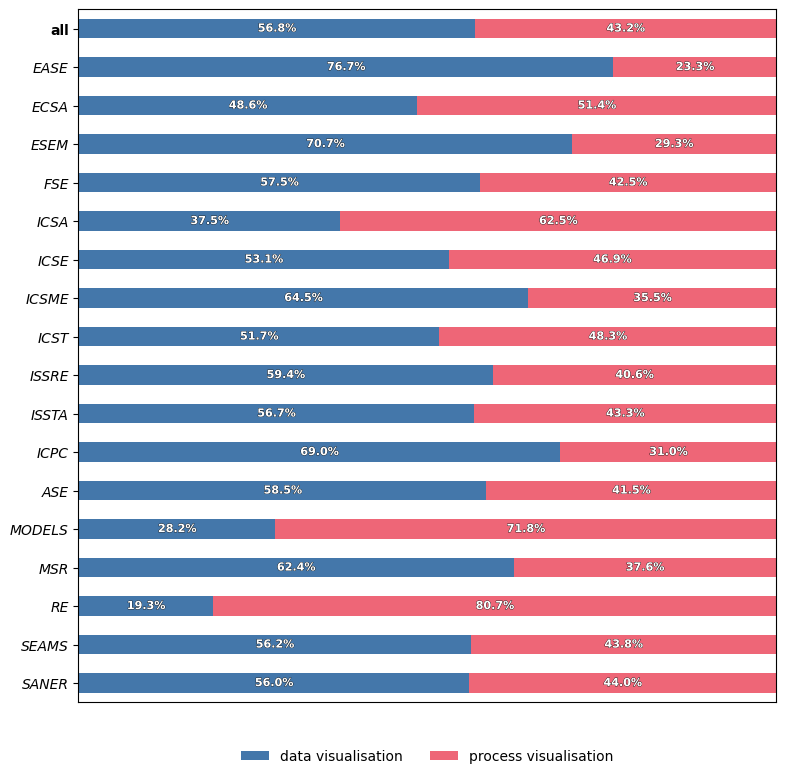

In [8]:
df_type_perc = classification_df[(classification_df["type"] != "INVALID") & (classification_df["type"] != "T")].groupby(["conf", "type"]).size().unstack(fill_value=0)
df_type_perc.loc["all"] = df_type_perc.sum()
df_type_perc = df_type_perc.div(df_type_perc.sum(axis=1), axis=0).mul(100).sort_index(ascending=False)#.round(1)#.reset_index()
df_type_perc.index = df_type_perc.index.map(lambda x: x.split("-")[1].strip("2024").upper() if not x=="all" else x)
ax = df_type_perc.plot(kind="barh", figsize=(9,9), stacked=True, fontsize=10, xticks=[], color=colors, ylabel="")
ax.legend(labels=["data visualisation", "process visualisation", "table"], loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False, fontsize=10)
ax.set_xlim((0,100))
ax.set_xmargin(0.01)

for label in ax.get_yticklabels():
    if label.get_text() == "all":
        label.set_fontweight("bold")
    else:
        label.set_style("italic")

for c in ax.containers:
    labels = [f'{w:0.1f}%' if (w := v.get_width()) > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', padding=0.3, color='white', fontsize=8, fontweight="bold",
                 path_effects=[patheffects.withStroke(linewidth=0.5, foreground='black')])


# Figure position

In [9]:
mention_df = pd.merge(mention_df_raw, classification_df, on=["conf", "doi", "fig_num"]).drop_duplicates(subset=['doi', 'fig_num'])
mention_df = mention_df[mention_df["type"] == "D"]
mention_df = mention_df[mention_df["category"]!="INVALID"] 


## Relative position of figure

In [10]:
mention_df["rel_pos"] = mention_df["fig_page"]/mention_df["total_pages"]

(0.0, 1.0)

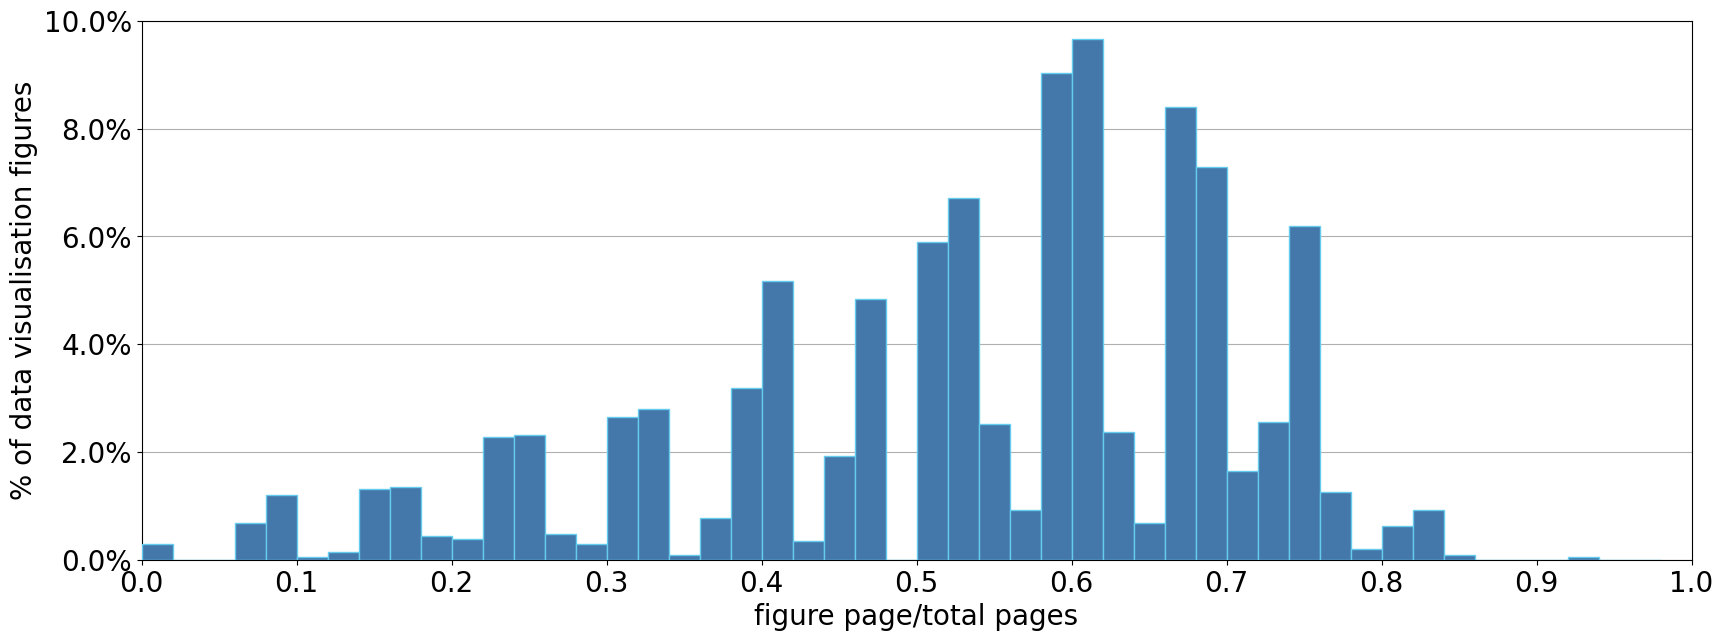

In [11]:
n_bins = 50
plt.hist(mention_df["rel_pos"], bins=np.arange(n_bins)/n_bins, weights=np.ones(len(mention_df["rel_pos"])) / len(mention_df["rel_pos"]), edgecolor=lightblue, color=blue, zorder=3)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(np.arange(11)/10, fontsize=fontsize)
plt.ylabel("% of data visualisation figures")
plt.xlabel("figure page/total pages")
plt.grid(axis="y", zorder=0)
plt.ylim((0,0.1))
plt.xlim((0,1))


# Figure mention

## Relative position of mention

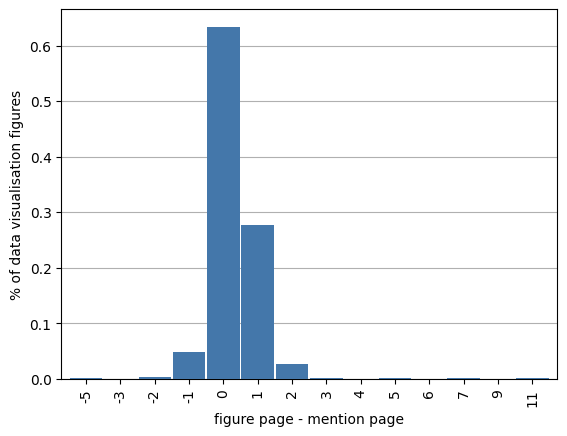

In [12]:
plt.style.use('default')
mention_df["rel_mention_page"] = mention_df["fig_page"] - mention_df["mention_page"]
rel_mention_page_counts = mention_df["rel_mention_page"].dropna().astype(int).value_counts()
ax = rel_mention_page_counts.div(sum(rel_mention_page_counts)).sort_index().plot.bar(color=blue, width=0.95, zorder=3)
# ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("figure page - mention page")
ax.set_ylabel("% of data visualisation figures")
ax.grid(axis="y", zorder=0)
# for container in ax.containers:
#     labels = [f'{w*100:0.1f}%' if (w := v.get_height()) > 0.02 else '' for v in container]
#     ax.bar_label(container, labels=labels)
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))


### Mention heading

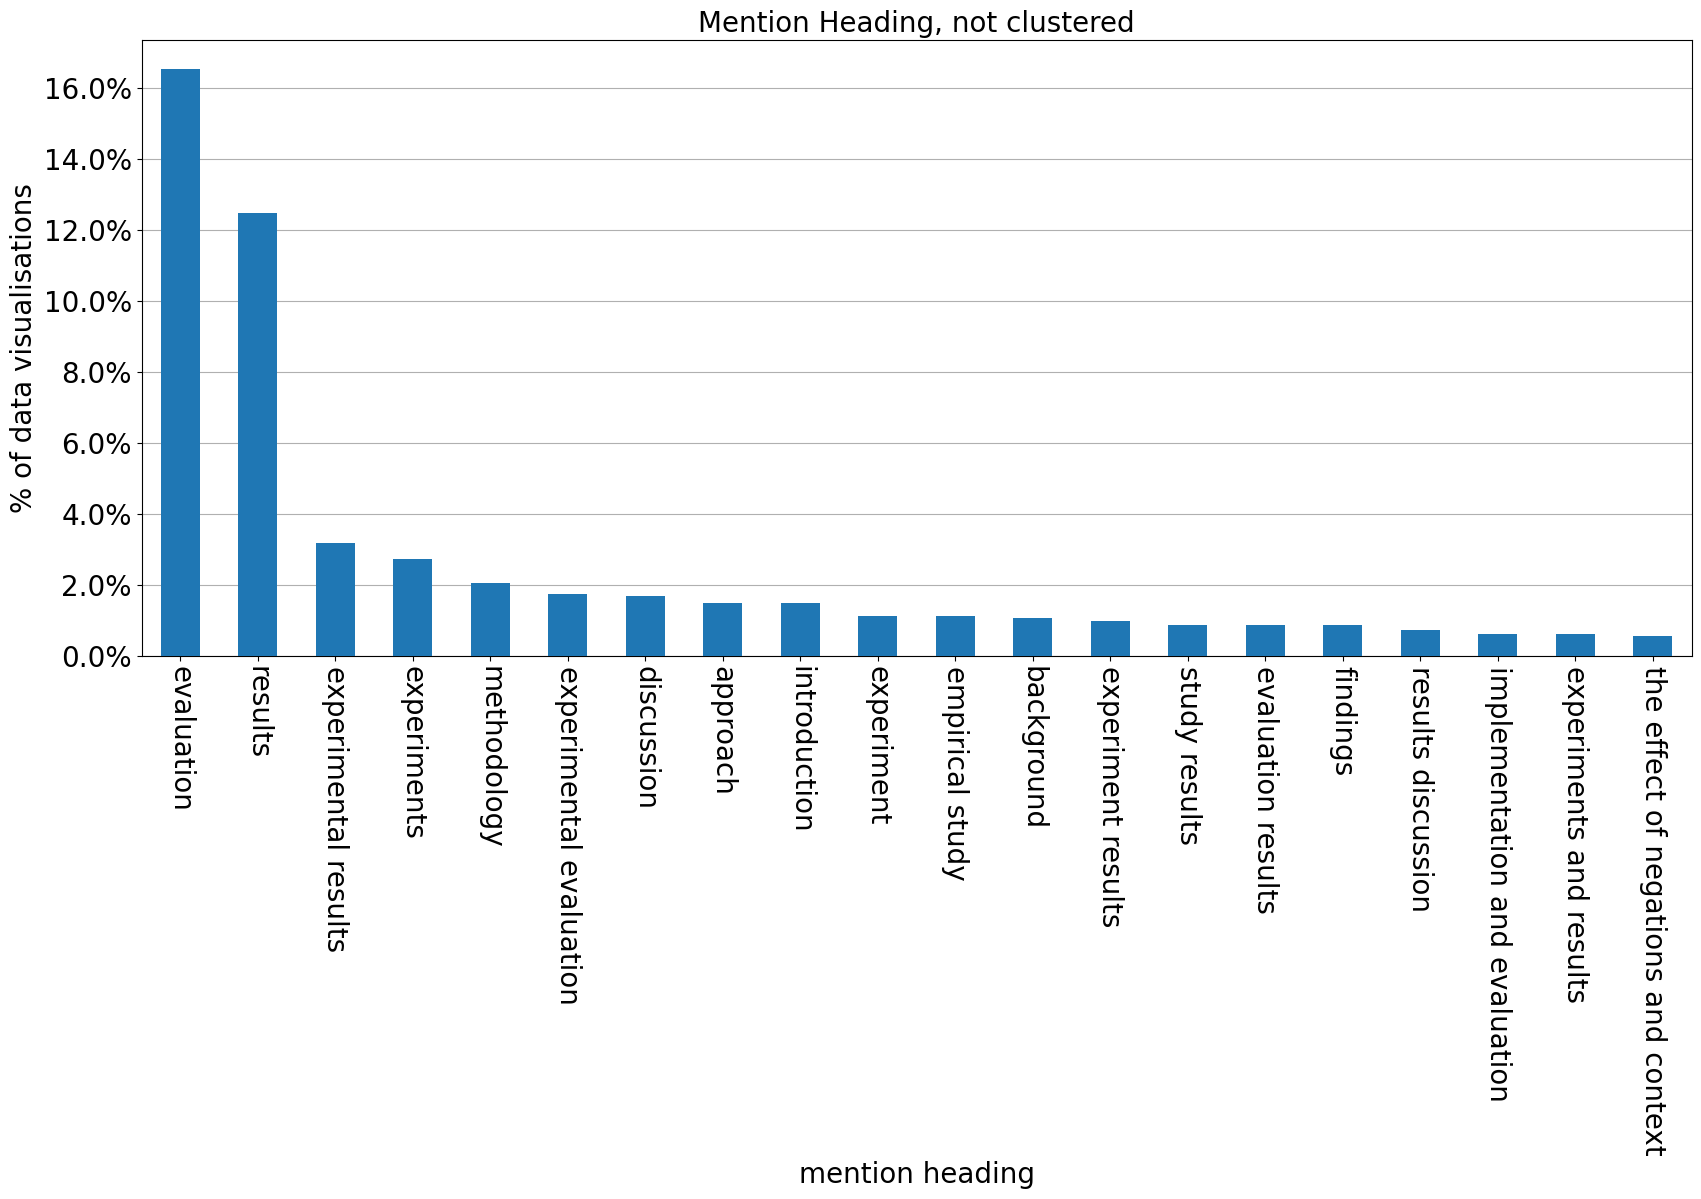

In [13]:
mention_headings = mention_df["mention_heading_txt"].dropna().astype(str).map(str.lower).apply(lambda x: re.sub(r"\s([0-9]+.*[0-9]+\s*)+", "", x))
mention_headings_counts = mention_headings.value_counts()
ax = mention_headings_counts.div(sum(mention_headings_counts)).head(20).plot.bar(rot=-90, zorder=3, figsize=(20,8), fontsize=20)
ax.set_title("Mention Heading, not clustered", fontsize=fontsize)
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_ylabel("% of data visualisations", fontsize=fontsize)
ax.set_xlabel("mention heading", fontsize=fontsize)
ax.grid(axis="y", zorder=0)


In [14]:
for i in mention_headings_counts.head(75).index:
    print(i, mention_headings_counts[i])

evaluation 265
results 200
experimental results 51
experiments 44
methodology 33
experimental evaluation 28
discussion 27
approach 24
introduction 24
experiment 18
empirical study 18
background 17
experiment results 16
study results 14
evaluation results 14
findings 14
results discussion 12
implementation and evaluation 10
experiments and results 10
the effect of negations and context 9
result analysis 9
api dataset analysis 9
dataset description and analysis 8
rq 8
motivation 8
results and analysis 8
study design 8
empirical findings 7
experimental setup 7
i 7
empirical results 7
and 7
graphcoder 6
analysis and results 6
study result 6
result and analysis 6
ali babar 6
empirical study on log density 6
results and discussion 6
stitching of call graphs.  having generated the partial call graph of every project and 6
criticising the task execution 6
experiment & result 5
preliminary study 5
results and findings 5
and maximum number of iterations 5
method 5
replicability study 5
rq1: anom

In [15]:
heading_mappings = {
    "results": [
        "results", "experimental results", "experiment results", "findings", "empirical findings", 
        "study result", "results and findings", "study results", "empirical results"
    ],
    "evaluation": [
        "evaluation", "experimental evaluation", "discussion", "result analysis", "api dataset analysis",
        "dataset description and analysis", "analysis", "validation", "repository analysis"
    ],
    "methodology": [
        "methodology", "approach", "study design", "experimental setup", "method", "experimental design",
        "implementation details"
    ],
    "experiment": [
        "experiments", "experiment", "empirical study", "replicability study"
    ],
    "RQ": [
        "rq", "rq1: anomaly types and anomaly-inducing code patterns", "rq4: prevalence of defects",
        "answering research questions"
    ],
    "introduction/\nbackground": [
        "background", "motivation", "preliminary study", "preliminaries", "background and motivation", "introduction"
    ],
    "results +\nevaluation": [
        "evaluation results", "results discussion", "results and analysis", "result and analysis", 
        "results and discussion", "analysis and results", "results and discussions"
    ],
    "experiment +\nresults": [
        "experiments and results", "experiment & result"
    ],
    "implementation +\nevaluation": [
        "implementation and evaluation"
    ]
}

filter_out = [
    "the effect of negations and context", "i", "and", "ali babar", "empirical study on log density", 
    "stitching of call graphs.  having generated the partial call graph of every project and", 
    "criticising the task execution", "and maximum number of iterations",
    "stitching of call graphs.  having generated the partial call graph of every project and",
    "developer feedback details.  developers of three companies interested in llm-based fl were invited to use the explanations and fl from autofl to debug real bugs from open-source",
    "2", "indicates that", "however,", "the ‘",
    "scale out evaluations.  we evaluate the scale-out properties of desql by increasing the",
    "birch (balanced iterative reducing and clustering using hierarchies) [",
    "when deleting or replacing input/output demos in the prompts.  (3)  more demos do not",
    "cve analysis results.  collective analysis.  we de￿ne  % coverage  as the percentage of",
    "to overcome the aforementioned limitations, we propose a novel concept called root cause change analysis (rcca) to identify the root cause changes of change-inducing incidents."
]

Total different headings: 458


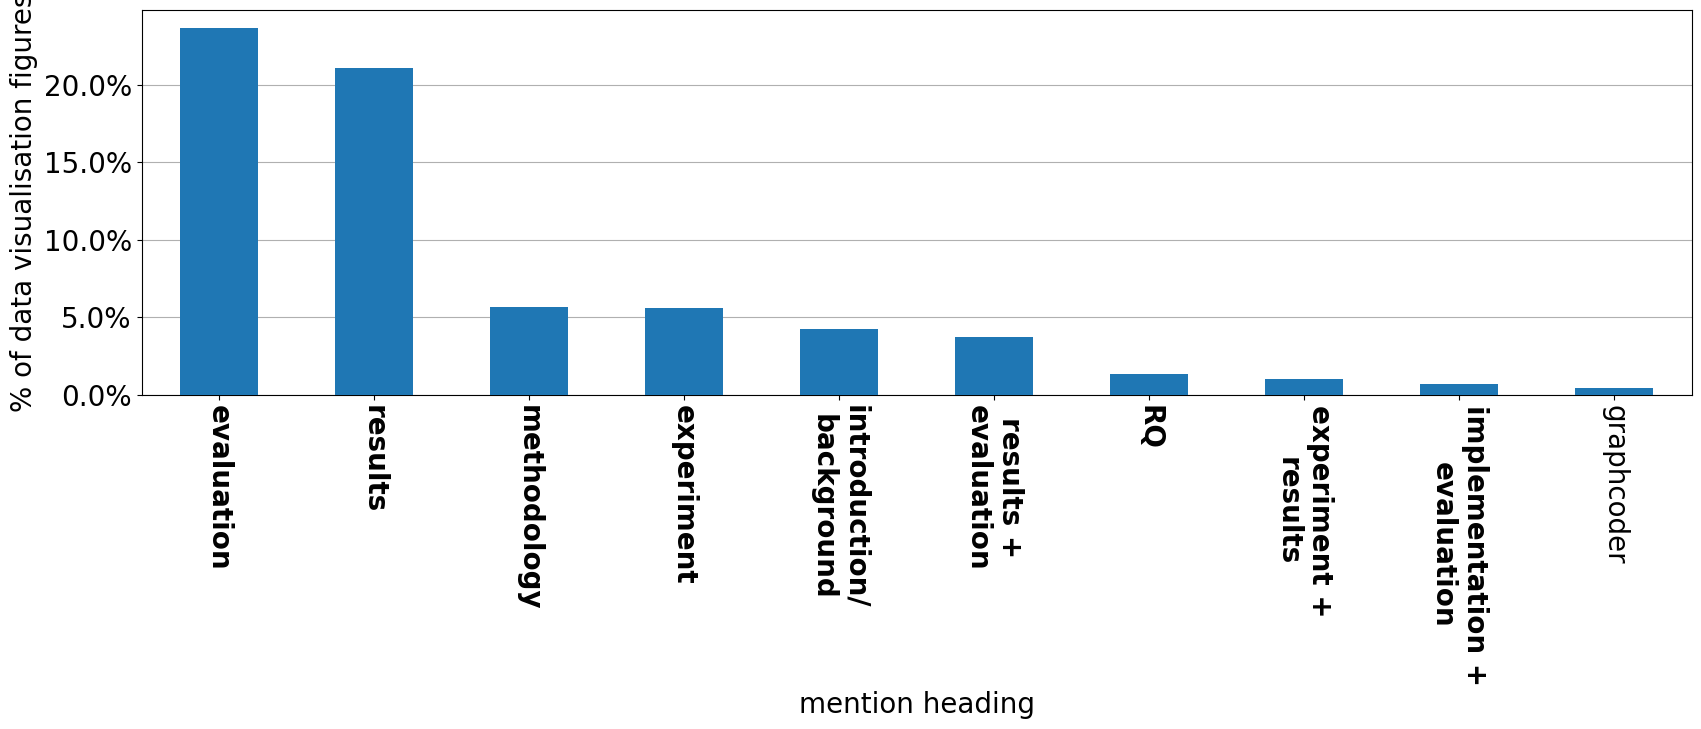

In [16]:
def cluster_heading(heading):
    if pd.isna(heading):
        return heading
    
    for cat, headings in heading_mappings.items():
        for h in headings:
            if heading == h:
                return cat
    
    if heading in filter_out:
        return None
    
    return heading

top_n = 10

print(f"Total different headings: {mention_df['mention_heading_txt'].nunique()}")
clustered_headings = mention_headings.apply(lambda x: cluster_heading(x))
mention_headings_clustered_counts = clustered_headings.value_counts()
ax = mention_headings_clustered_counts.div(sum(mention_headings_clustered_counts)).head(top_n).plot.bar(rot=-90, title="Mention Heading, clustered", zorder=3, figsize=(20,5), fontsize=fontsize)
ax.set_title("")
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_ylabel("% of data visualisation figures", fontsize=fontsize)
ax.set_xlabel("mention heading", fontsize=fontsize)
ax.grid(axis="y", zorder=0)

for label in ax.get_xticklabels():
    if label.get_text() in heading_mappings.keys():
        label.set_fontweight("bold")

## Relative position of figure by category

Excludes 'Text Based' as there is only 3


Text(207.24999999999997, 0.5, 'chart category')

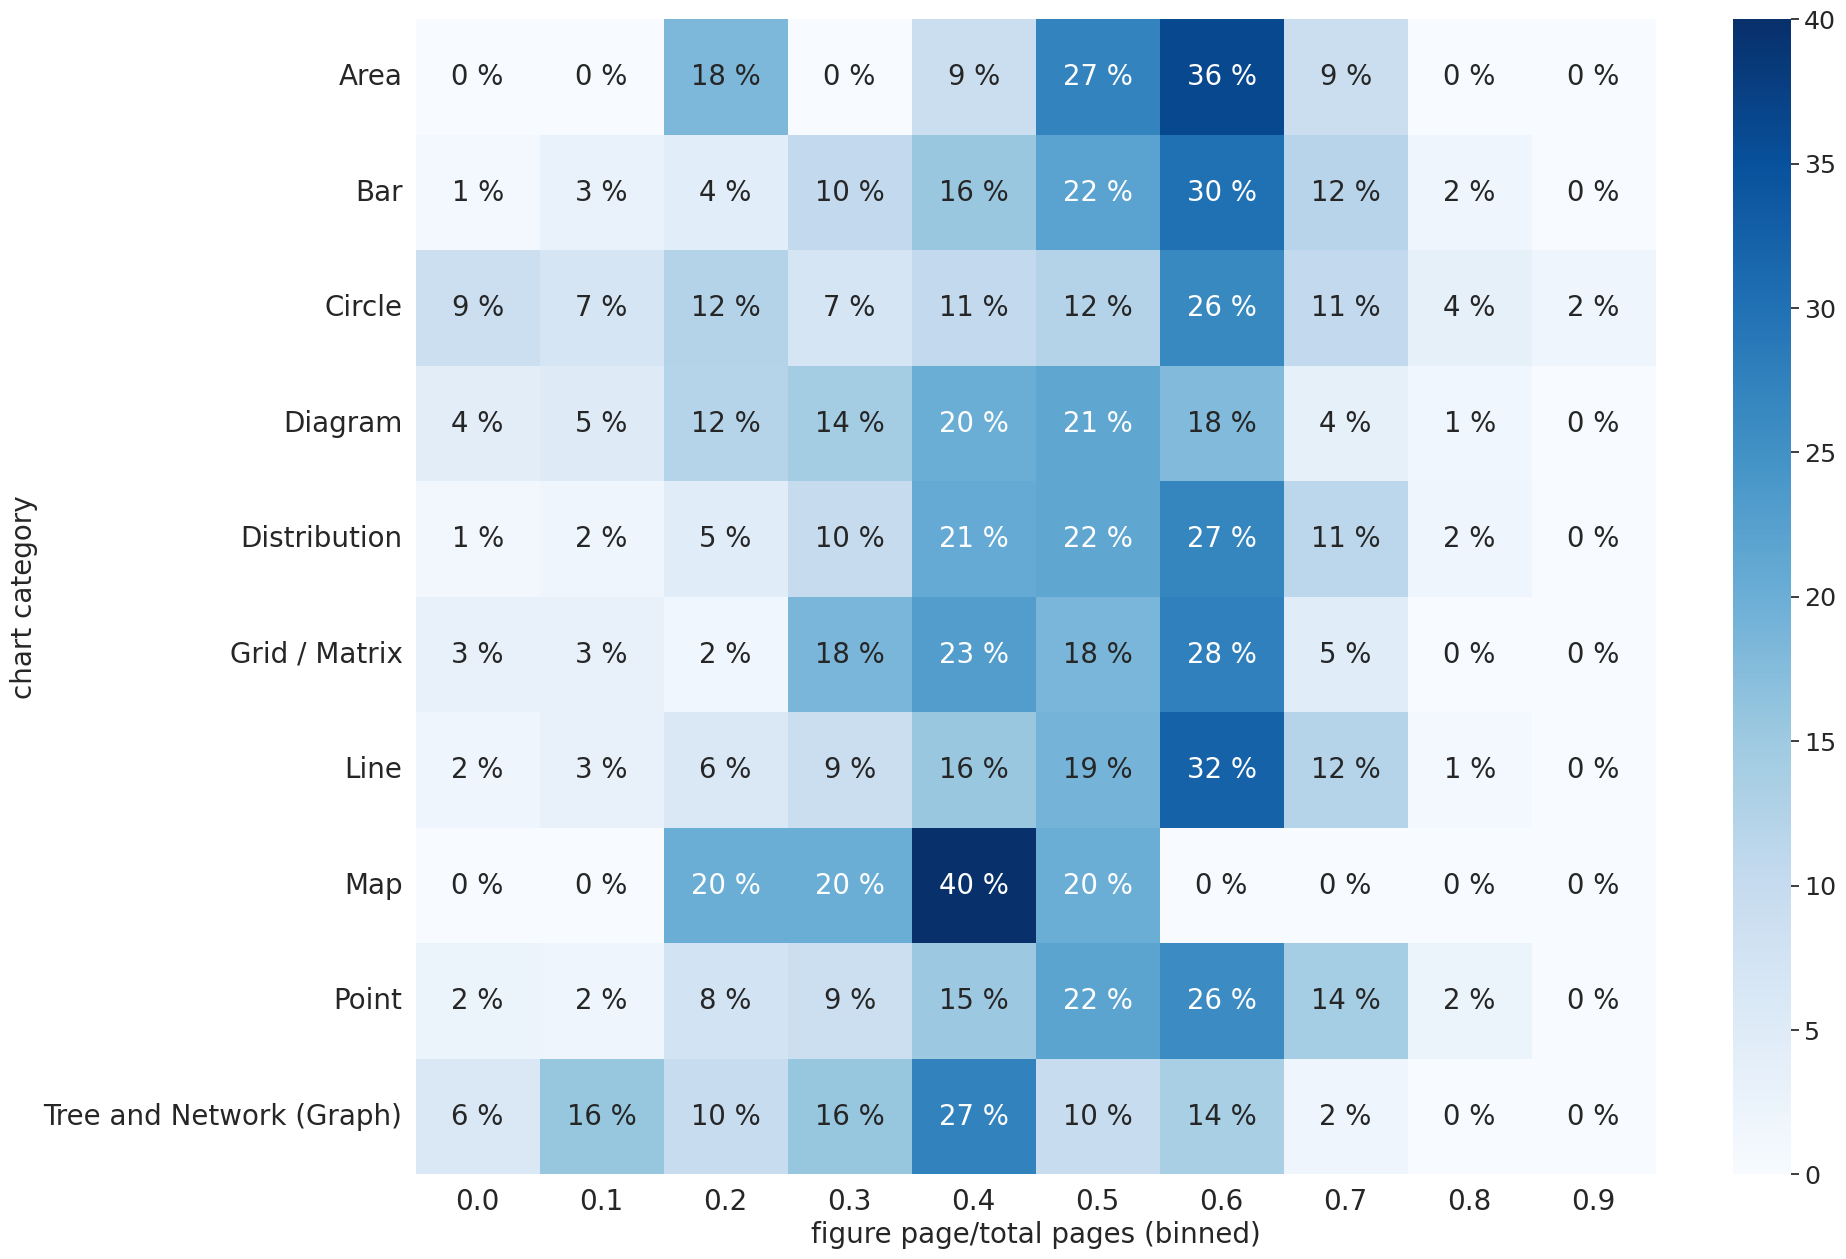

In [19]:
print("Excludes 'Text Based' as there is only", len(mention_df[mention_df["category"] == "Text Based"]))

n_bins = 10
mention_df["rel_pos_hist"] = pd.cut(mention_df["rel_pos"], bins=np.arange(n_bins+1)/n_bins, labels=False)
heatmap_table = pd.crosstab(mention_df["category"], mention_df["rel_pos_hist"], normalize="index")*100
heatmap_table = heatmap_table[heatmap_table.index != "Text Based"]
plt.figure(figsize=(20,15))
sns.set(font_scale=1.65)
ax = sns.heatmap(heatmap_table, cmap="Blues", annot=True, fmt=".0f")
ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), fontsize=fontsize)
ax.xaxis.set_ticklabels([f"{x:.1f}" for x in np.arange(n_bins)/n_bins], fontsize=fontsize)
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.xlabel("figure page/total pages (binned)", fontsize=fontsize)
plt.ylabel("chart category", fontsize=fontsize)

In [20]:
plt.style.use("default")

# Chart categories

category
Area                         1.024924
Bar                         24.388539
Circle                       2.422548
Diagram                      5.590496
Distribution                20.382017
Grid / Matrix                2.608898
Line                        32.471465
Map                          0.139762
Point                        9.084556
Text Based                   0.116469
Tree and Network (Graph)     1.770324
Name: all, dtype: float64

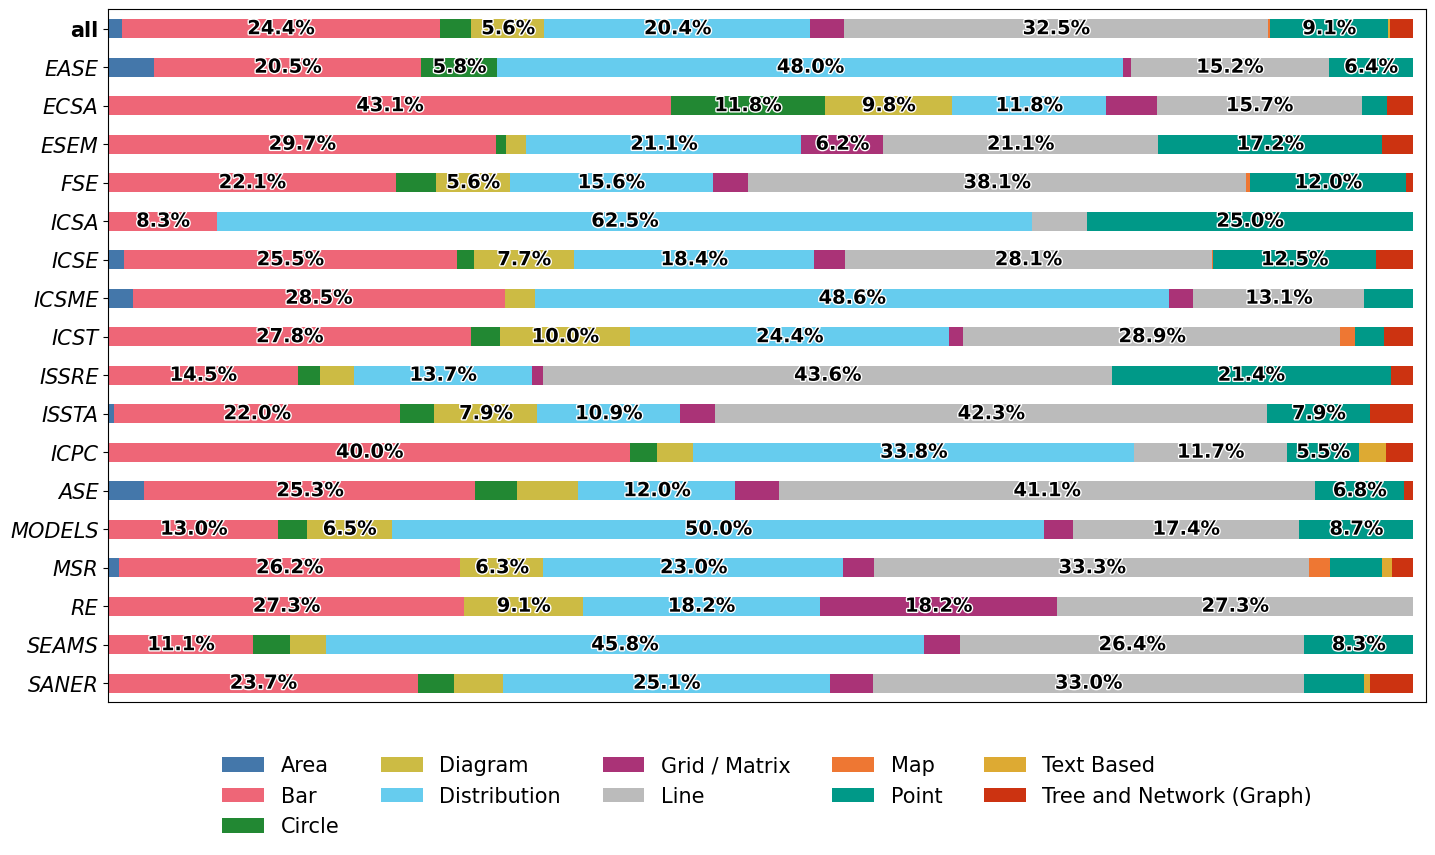

In [21]:
df_category_perc = classification_df[(classification_df["category"] != "INVALID") & pd.notna(classification_df["category"])].groupby(["conf", "category"]).size().unstack(fill_value=0)
df_category_perc.loc["all"] = df_category_perc.sum()
df_category_perc = df_category_perc.div(df_category_perc.sum(axis=1), axis=0).mul(100).sort_index(ascending=False)#.round(1)#.reset_index()
df_category_perc.index = df_category_perc.index.map(lambda x: x.split("-")[1].strip("2024").upper() if not x=="all" else x)
ax = df_category_perc.plot(kind="barh", figsize=(17,9), stacked=True, fontsize=15, xticks=[], color=colors, ylabel="")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, frameon=False, fontsize=15)
ax.set_xmargin(0.01)

for label in ax.get_yticklabels():
    if label.get_text() == "all":
        label.set_fontweight("bold")
    else:
        label.set_style("italic")

for c in ax.containers:
    labels = [f'{w:0.1f}%' if ((w := v.get_width()) > 0 and w >= 5) else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', padding=0.3, color='black', fontsize=14, fontweight="bold",
                 path_effects=[patheffects.withStroke(linewidth=2, foreground='white')])

df_category_perc.loc["all"]

In [22]:
cat_color_dict = {
    "Area": blue,
    "Bar": pink,
    "Circle": green,
    "Diagram": dirtyellow,
    "Distribution": lightblue,
    "Grid/Matrix": purple,
    "Line": grey,
    "Map": orange,
    "Point": green2,
    "Text Based": yellow,
    "Tree and Network (Graph)": red
}

In [23]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

print("percentages are of all categorized visualisations")

category_counts_df = classification_df.value_counts(["category", "subsubcategory"]).reset_index()
category_counts_df.columns = ["category", "subsubcategory", "count"]

fig = px.treemap(category_counts_df, 
                 path=["category", "subsubcategory"],
                 values="count",
                 color=category_counts_df["category"],
                 color_discrete_map=cat_color_dict,
                 width=650*0.8, height=750*0.8)
fig.data[0].textinfo = 'label+text+percent entry'
fig.update_layout(
    font=dict(
        family="Open Sans",
        size=40
    ),
    margin=dict(l=0, r=0, t=0, b=0)
)
fig.show(renderer="iframe")
fig.write_image("treemap.png")

percentages are of all categorized visualisations


In [24]:
category_counts_df["perc"] = category_counts_df["count"].div(sum(category_counts_df["count"])).mul(100)
print(category_counts_df[["category", "subsubcategory", "perc"]])

                    category               subsubcategory       perc
0                       Line                   Line Graph  30.444910
1               Distribution         Box-And-Whisker Plot  15.234102
2                        Bar            Grouped Bar Chart  13.324016
3                      Point                 Scatter Plot   6.871652
4                        Bar                    Bar Chart   6.312602
5                        Bar            Stacked Bar Chart   4.612159
6                    Diagram                 Venn Diagram   3.261123
7               Distribution                    Histogram   3.098067
8              Grid / Matrix                     Heat Map   2.608898
9                     Circle                    Pie Chart   1.863499
10                     Point                   Trend Line   1.747030
11                      Line                    Star Plot   1.351037
12  Tree and Network (Graph)                        Graph   1.234568
13              Distribution      

In [26]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

print("percentages are of all categorized figures")

category_counts_df = classification_df.drop_duplicates(subset=['doi', 'fig_num']).value_counts(["category", "subsubcategory"]).reset_index()
category_counts_df.columns = ["category", "subsubcategory", "count"]

fig = px.treemap(category_counts_df, 
                 path=["category", "subsubcategory"],
                 values="count",
                 color=category_counts_df["category"],
                 color_discrete_map=cat_color_dict,
                 width=650*0.8, height=750*0.8)
fig.data[0].textinfo = 'label+text+percent entry'
fig.update_layout(
    font=dict(
        family="Open Sans",
        size=40
    ),
    margin=dict(l=0, r=0, t=0, b=0)
)
fig.show(renderer="iframe")
fig.write_image("treemap.png")

percentages are of all categorized figures


In [27]:
plt.style.use("default")

## Dimensionality

In [28]:
print(classification_df["dimensionality"].dropna().astype(int).value_counts()/len(classification_df["dimensionality"].dropna())*100)


dimensionality
2    99.697111
3     0.302889
Name: count, dtype: float64


## Multiplicity

per figure, not per visualization!
multiplicity
Multipanel     42.158761
Single         41.432720
Grouped        14.133591
Combination     2.274927
Name: count, dtype: float64


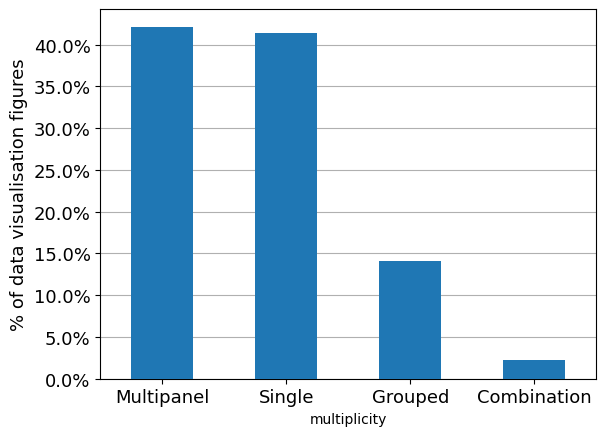

In [30]:
multiplicity_counts = classification_df[classification_df["multiplicity"]!="INVALID"].drop_duplicates(subset=['doi', 'fig_num'])["multiplicity"].dropna().value_counts()
ax = multiplicity_counts.div(sum(multiplicity_counts)).plot.bar(stacked=True, zorder=3, rot=0, fontsize=13)
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_ylabel("% of data visualisation figures", fontsize=13)
ax.grid(axis="y", zorder=0)
print("per figure, not per visualization!")
print(multiplicity_counts.div(sum(multiplicity_counts)).mul(100))


per figure, not per visualization!


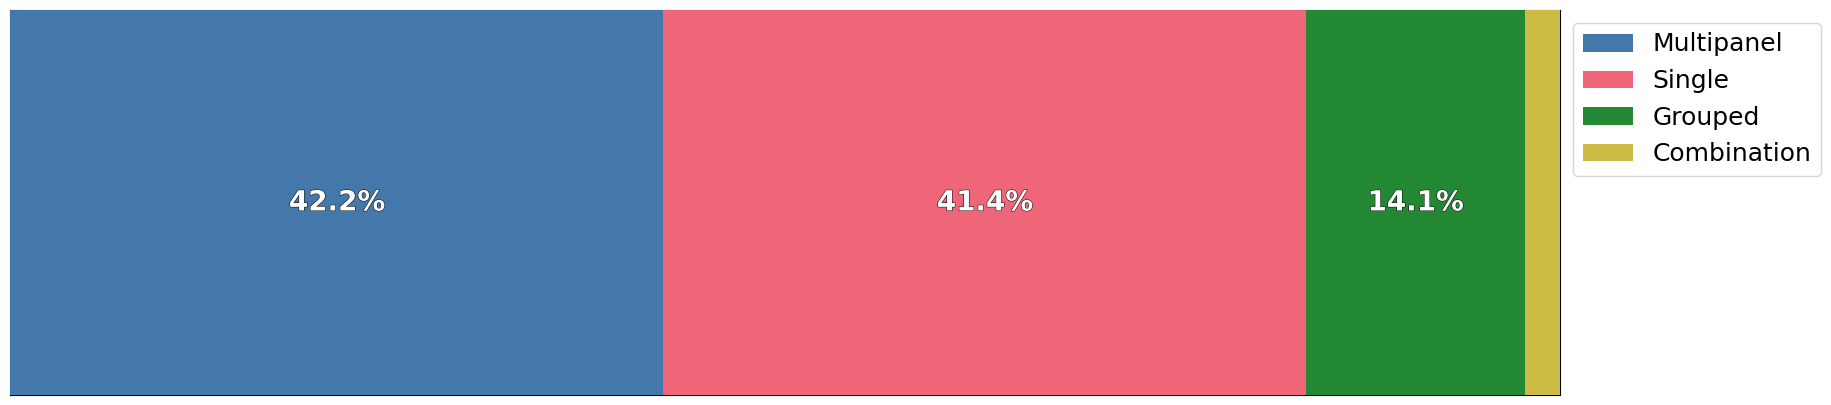

In [31]:
multiplicity_counts = classification_df[classification_df["multiplicity"]!="INVALID"].drop_duplicates(subset=['doi', 'fig_num'])["multiplicity"].dropna().value_counts()
ax = pd.DataFrame(multiplicity_counts.div(sum(multiplicity_counts))).T.plot.barh(stacked=True, zorder=3, rot=0, fontsize=13, color=colors, width=1, figsize=(20,5))
# ax.yaxis.set_major_formatter(PercentFormatter(1))
# ax.set_ylabel("% of data visualisation figures", fontsize=13)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0,1)
ax.set_ylim(-0.5,0.5)
ax.grid(axis="y", zorder=0)
ax.margins(x=0, y=0, tight=True)
print("per figure, not per visualization!")
ax.legend(bbox_to_anchor=(1.0, 1.0), fontsize=18)

for c in ax.containers:
    labels = [f'{w*100:0.1f}%' if (w := v.get_width()) > 0.03 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', padding=0.3, color='white', fontsize=20, fontweight="bold",
                 path_effects=[patheffects.withStroke(linewidth=0.7, foreground='black')])



### Number of panels

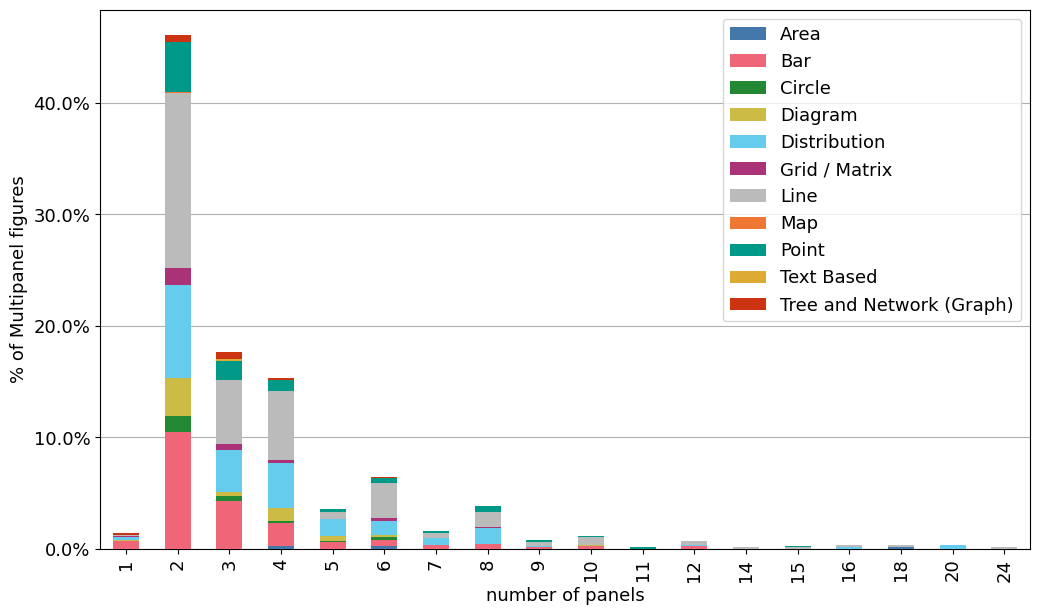

In [32]:
n_panels_cat_df = classification_df[classification_df["multiplicity"]=="Multipanel"].drop_duplicates(subset=['doi', 'fig_num']).dropna(subset=["n_panels"])
n_panels_cat_df["n_panels"] = n_panels_cat_df["n_panels"].astype(int)
n_panels_cat_df = n_panels_cat_df.groupby(["n_panels", "category"]).size()
n_panels_cat_df = n_panels_cat_df.div(sum(n_panels_cat_df)).unstack(fill_value=0)
ax = n_panels_cat_df.plot.bar(stacked=True, color=colors, zorder=3, figsize=(12,7), fontsize=13)
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("number of panels", fontsize=13)
ax.set_ylabel("% of Multipanel figures", fontsize=13)
ax.legend(fontsize=13)
ax.grid(axis="y", zorder=0)

# Image properties

In [43]:
properties_df = pd.merge(properties_df, classification_df, on=["conf", "doi", "fig_num"])
properties_df = properties_df[properties_df["type"] == "D"]


## Proportion

Text(0.5, 0, 'height/width')

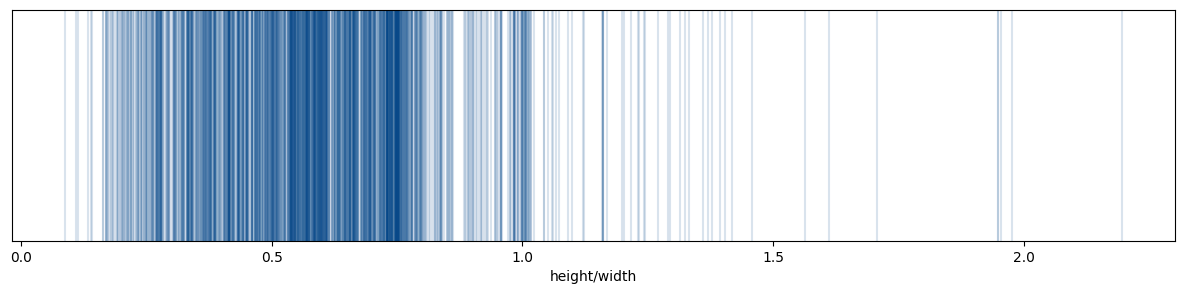

In [44]:
properties_df["proportion"] = properties_df["height"]/properties_df["width"]
plt.figure(figsize=(15,3))
not_multipanel_df = properties_df[properties_df["multiplicity"] != "Multipanel"]
plt.scatter(x=not_multipanel_df["proportion"], y=np.zeros(len(not_multipanel_df)), alpha=0.15, s=30*1000, color=darkblue, marker="|")
plt.yticks([])
plt.xlabel("height/width")

In [45]:
print("horizontal", len(not_multipanel_df[not_multipanel_df["proportion"] < 1])/len(not_multipanel_df)*100)
print("square", len(not_multipanel_df[not_multipanel_df["proportion"] == 1])/len(not_multipanel_df)*100)
print("vertical", len(not_multipanel_df[not_multipanel_df["proportion"] > 1])/len(not_multipanel_df)*100)

horizontal 94.26229508196722
square 0.4098360655737705
vertical 5.327868852459016


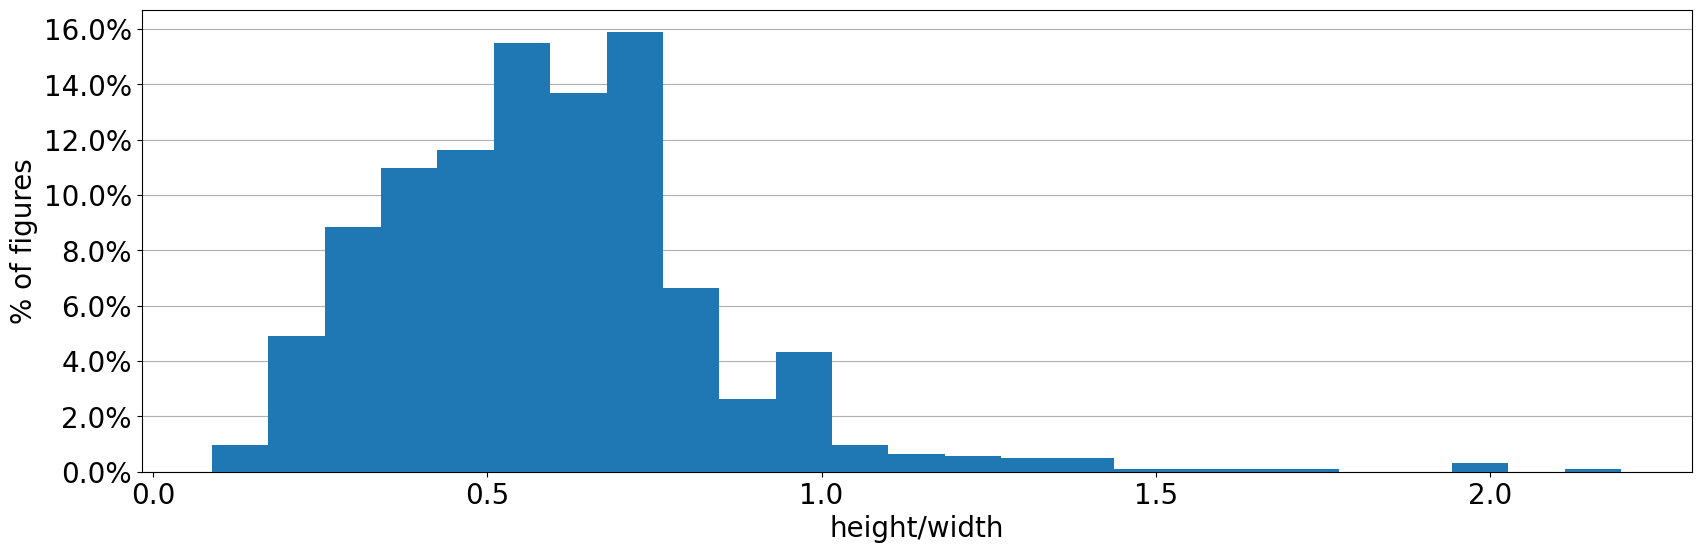

In [46]:
properties_df["proportion"] = properties_df["height"]/properties_df["width"]
plt.figure(figsize=(15,3))
not_multipanel_df = properties_df[properties_df["multiplicity"] != "Multipanel"]
ax = not_multipanel_df["proportion"].plot.hist(bins=25, weights=np.ones(len(not_multipanel_df["proportion"])) / len(not_multipanel_df["proportion"]), fontsize=fontsize, figsize=(20,6), zorder=3)
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel("height/width", fontsize=fontsize)
ax.set_ylabel("% of figures", fontsize=fontsize)
ax.grid(axis="y", zorder=0)


## Colors

### BW vs. Color

In [47]:
rgb_diff_thresh = 10

In [48]:
def is_in_color(colors) -> bool:
    for color, frac in ast.literal_eval(colors):
        r, g, b = webcolors.hex_to_rgb("#" + str(color))
        diff = max([abs(r-g), abs(r-b), abs(g-b)])
        if diff > rgb_diff_thresh:
            return True
        
    return False

properties_df["color"] = properties_df.apply(lambda row: is_in_color(row.colors), axis=1)


color
True     92.382949
False     7.617051
Name: count, dtype: float64


Text(0.5, 0, '')

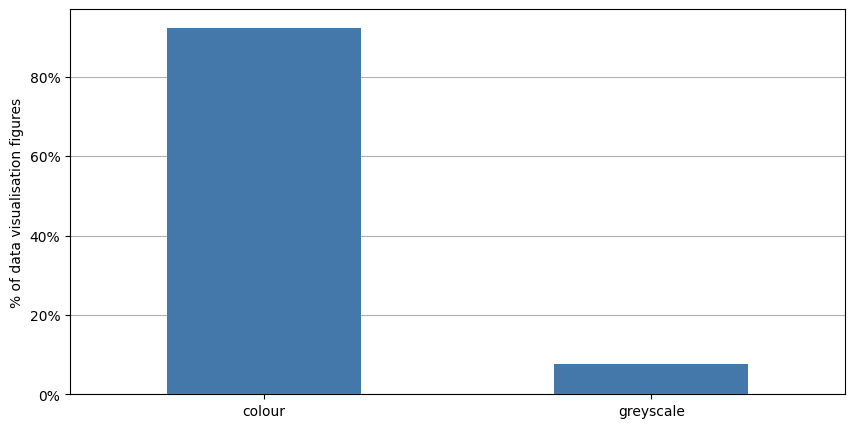

In [49]:
print(properties_df["color"].value_counts().div(len(properties_df)).mul(100))

bw_counts = properties_df["color"].value_counts()
ax = bw_counts.div(sum(bw_counts)).plot.bar(figsize=(10,5), color=blue, zorder=3)
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.grid(axis="y", zorder=0)
ax.set_xticklabels(["colour", "greyscale"], rotation=0)
ax.set_ylabel("% of data visualisation figures")
ax.set_xlabel("")


In [50]:
def closest_color(color):  # source: https://stackoverflow.com/questions/70967119/webcolors-has-no-attribute-css3-hex-to-names    
    min_colors = {}
    color = webcolors.hex_to_rgb("#" + str(color))
    for name in webcolors.names("css3"):
        r_c, g_c, b_c = webcolors.name_to_rgb(name)
        rd = (r_c - color[0]) ** 2
        gd = (g_c - color[1]) ** 2
        bd = (b_c - color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    
    cluster_name = min_colors[min(min_colors.keys())]
    
    return cluster_name

whites = ["whitesmoke", "white", "snow", "seashell", "floralwhite", "ivory", "honeydew", "mintcream", "azure", "ghostwhite", "lavenderblush"]
greys = ["dimgray", "dimgrey", "gray", "grey", "darkgray", "darkgrey", "silver", "lightgray", "lightgrey", "gainsboro", "lightslategray", "lightslategrey", "slategray", "slategrey"]
blacks = ["black", "darkslategray", "darkslategrey"]

color
True     92.382949
False     7.617051
Name: count, dtype: float64


Text(0.5, 0, '')

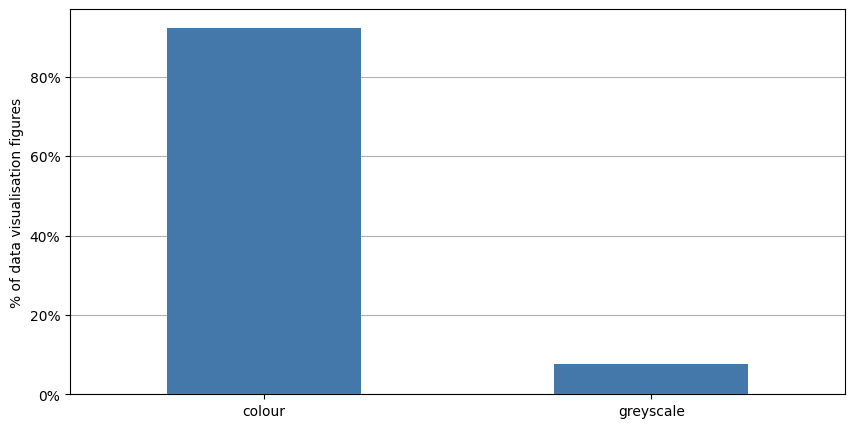

In [55]:
print(properties_df["color"].value_counts().div(len(properties_df)).mul(100))

bw_counts = properties_df["color"].value_counts()
ax = bw_counts.div(sum(bw_counts)).plot.bar(figsize=(10,5), color=blue, zorder=3)
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.grid(axis="y", zorder=0)
ax.set_xticklabels(["colour", "greyscale"], rotation=0)
ax.set_ylabel("% of data visualisation figures")
ax.set_xlabel("")

### Colors

In [56]:
all_color_counts = defaultdict(float)

def fill_all_color_counts(colors):
    colors = ast.literal_eval(colors)[:30]
    for color, frac in colors:
        all_color_counts[color] += frac

properties_df.apply(lambda row: fill_all_color_counts(row.colors), axis=1)

norm_val = sum(all_color_counts.values())
for key, val in all_color_counts.items():
    all_color_counts[key] /= norm_val

In [57]:
num_colors = len(all_color_counts)

width = 1000
height = 250
big_palette = Image.new("RGB", (width, height))

running_width = 0
color_counts = sorted(all_color_counts.items(), key=lambda x: x[1], reverse=True)

this_w = 0
these_cols = []
for color, frac in color_counts:
    stripe_width = round(width*frac)
    if this_w != stripe_width:
        these_cols = sorted(these_cols)
        for this_col in these_cols:
            try:
                for x in range(running_width, this_w + running_width + 1):
                    for y in range(height):
                        big_palette.putpixel((x, y), webcolors.hex_to_rgb(f"#{this_col}"))
                    running_width += 1
            except IndexError:
                break
            
        this_w = stripe_width
        these_cols = []
    if stripe_width == 0:
        break
    
    these_cols.append(color)


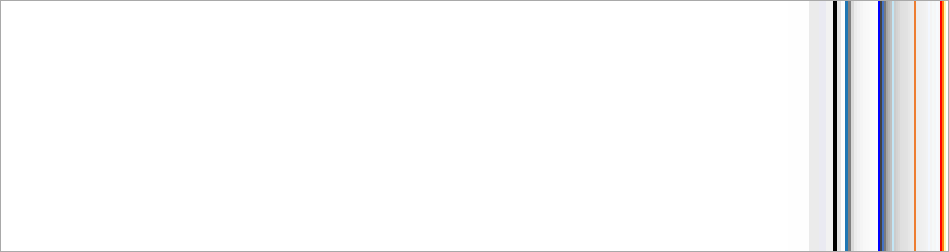

In [58]:
big_palette = big_palette.crop((0, 0, running_width, height)) 
big_palette_border = ImageOps.expand(big_palette,border=1,fill='darkgrey')
display(big_palette_border)


In [59]:
color_counts_no_white = []
for color, frac in color_counts:
    r,g,b = webcolors.hex_to_rgb(f"#{color}")
    if r >= 250 and g >= 250 and b >= 250:
        continue
    color_counts_no_white.append((color, frac))

norm_no_whites = sum([c[1] for c in color_counts_no_white])
color_counts_no_white = [(c, f/norm_no_whites) for (c, f) in color_counts_no_white]

In [60]:
palette_without_white = Image.new("RGB", (width, height))

running_width = 0
color_counts_no_whites = sorted(color_counts_no_white, key=lambda x: x[1], reverse=True)

this_w = 0
these_cols = []
for color, frac in color_counts_no_whites:
    stripe_width = round(width*frac)
    if this_w != stripe_width:
        these_cols = sorted(these_cols)
        for this_col in these_cols:
            try:
                for x in range(running_width, this_w + running_width + 1):
                    for y in range(height):
                        palette_without_white.putpixel((x, y), webcolors.hex_to_rgb(f"#{this_col}"))
                    running_width += 1
            except IndexError:
                break
            
        this_w = stripe_width
        these_cols = []
    if stripe_width == 0:
        break
    
    these_cols.append(color)

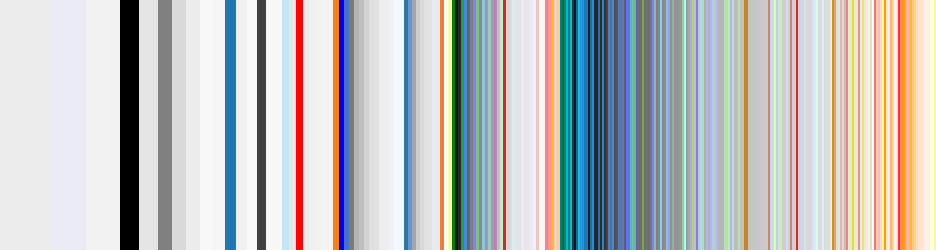

In [61]:
palette_without_white = palette_without_white.crop((0, 0, running_width, height)) 
display(palette_without_white)


In [62]:
color_counts_no_greys = []
for color, frac in color_counts:
    r,g,b = webcolors.hex_to_rgb(f"#{color}")
    diff = max([abs(r-g), abs(r-b), abs(g-b)])
    if diff <= rgb_diff_thresh:
        continue
    color_counts_no_greys.append((color, frac))

norm_no_greys = sum([c[1] for c in color_counts_no_greys])
color_counts_no_greys = [(c, f/norm_no_greys) for (c, f) in color_counts_no_greys]


In [63]:
palette_without_greys = Image.new("RGB", (width, height))

running_width = 0
color_counts_no_greys = sorted(color_counts_no_greys, key=lambda x: x[1], reverse=True)
this_w = 0
these_cols = []
for color, frac in color_counts_no_greys:
    stripe_width = round(width*frac)
    if this_w != stripe_width:
        these_cols = sorted(these_cols)
        for this_col in these_cols:
            try:
                for x in range(running_width, this_w + running_width + 1):
                    for y in range(height):
                        palette_without_greys.putpixel((x, y), webcolors.hex_to_rgb(f"#{this_col}"))
                    running_width += 1
            except IndexError:
                break
            
        this_w = stripe_width
        these_cols = []
    if stripe_width == 0:
        break
    
    these_cols.append(color)

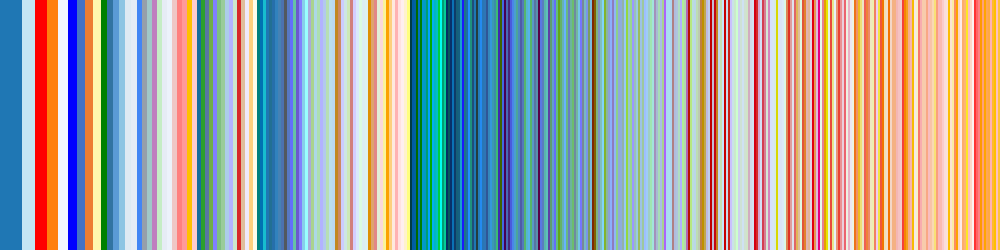

In [64]:
palette_without_greys = palette_without_greys.crop((0, 0, running_width, height)) 
display(palette_without_greys)

In [65]:
def closest_color(color):  # source: https://stackoverflow.com/questions/70967119/webcolors-has-no-attribute-css3-hex-to-names    
    min_colors = {}
    color = webcolors.hex_to_rgb("#" + str(color))
    for name in webcolors.names("css3"):
        r_c, g_c, b_c = webcolors.name_to_rgb(name)
        rd = (r_c - color[0]) ** 2
        gd = (g_c - color[1]) ** 2
        bd = (b_c - color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    
    cluster_name = min_colors[min(min_colors.keys())]
    
    return cluster_name

whites = ["whitesmoke", "white", "snow", "seashell", "floralwhite", "ivory", "honeydew", "mintcream", "azure", "ghostwhite", "lavenderblush"]
greys = ["dimgray", "dimgrey", "gray", "grey", "darkgray", "darkgrey", "silver", "lightgray", "lightgrey", "gainsboro", "lightslategray", "lightslategrey", "slategray", "slategrey"]
blacks = ["black", "darkslategray", "darkslategrey"]

In [66]:
color_counts_clustered = defaultdict(int)

for color, frac in color_counts:
    cluster_color = closest_color(color)
    if cluster_color in whites or cluster_color in greys or cluster_color in blacks:
        continue
    color_counts_clustered[closest_color(color)] += frac

norm = 1/sum(color_counts_clustered.values())
for c in color_counts_clustered:
    color_counts_clustered[c] *= norm

/tmp/ipykernel_40043/846981677.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



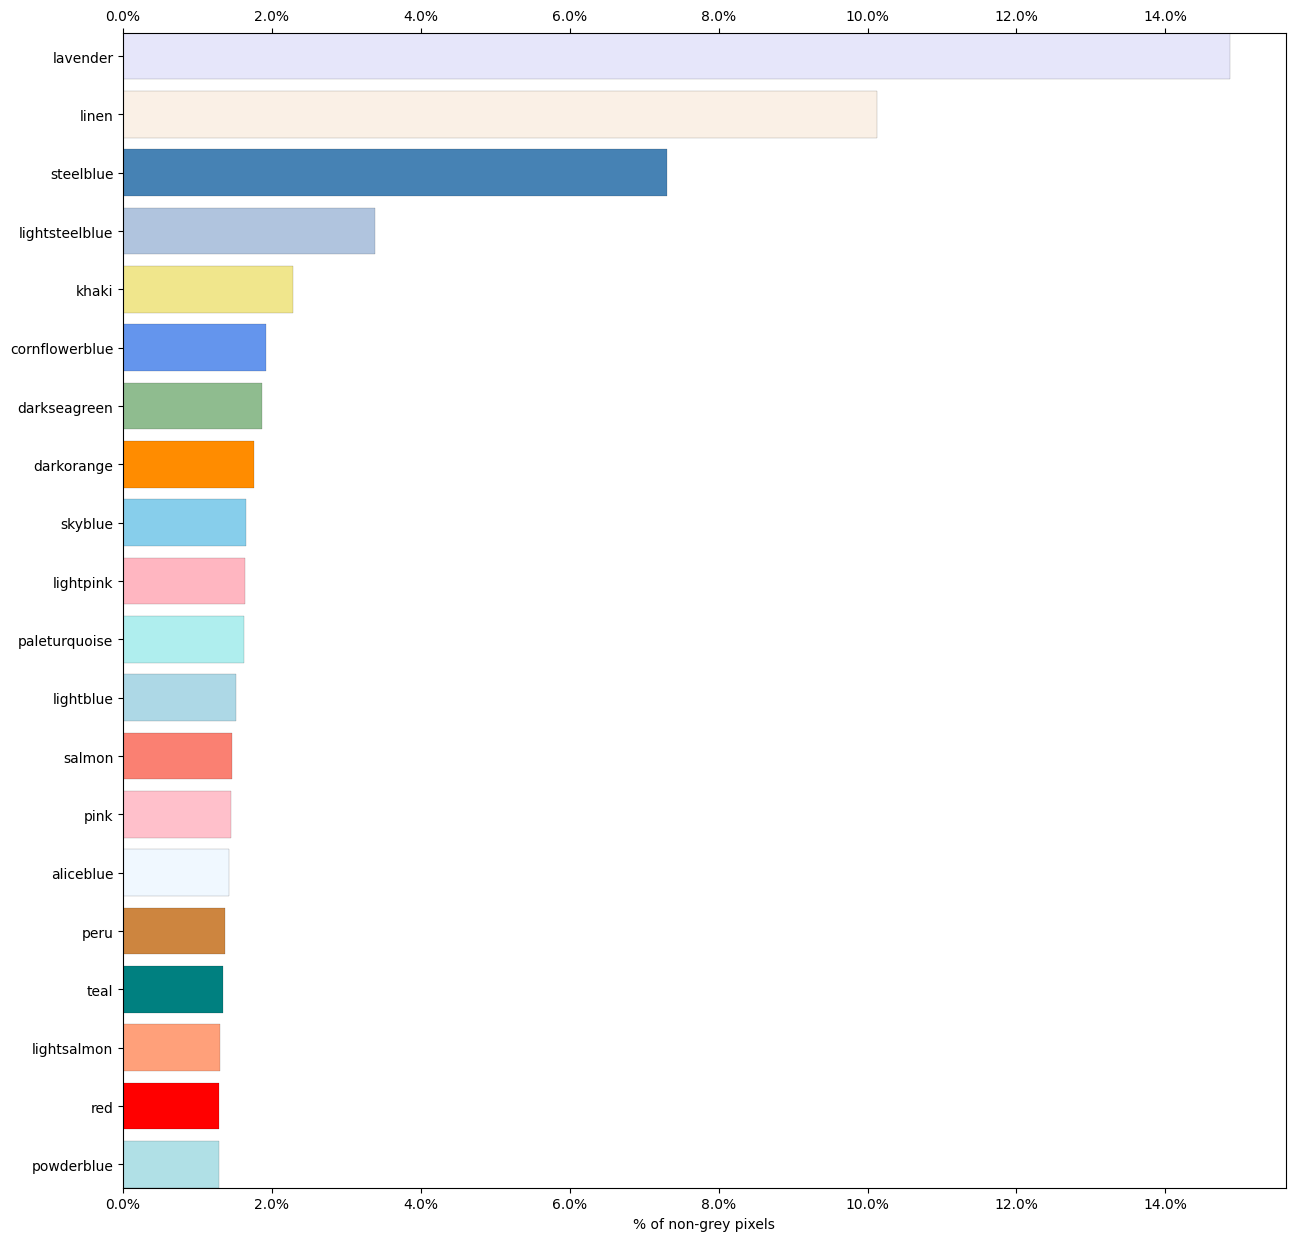

In [67]:
sorted_color_counts_clustered = sorted(color_counts_clustered.items(), key=lambda x: x[1])[len(color_counts_clustered)-20:]
fig, ax = plt.subplots(figsize=(15,15))
# Excluding white:
ax.barh(*zip(*sorted_color_counts_clustered), color=[c[0] for c in sorted_color_counts_clustered], edgecolor="black", linewidth=0.1)
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.margins(y=0)
ax.set_xlabel("% of non-grey pixels")
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
fig.show()

### Color palettes

In [68]:
palette_num = 5

def get_color_palette(row) -> list:
    clustered_d = defaultdict(int)

    for color, frac in ast.literal_eval(row.colors):
        if len(clustered_d) >= palette_num:
            break

        cluster_col = closest_color(color)
        if cluster_col in whites:
            continue
        elif cluster_col in greys:
            continue
        elif cluster_col in blacks:
            continue
        clustered_d[cluster_col] += frac        
    
    palette = [x[0] for x in sorted(clustered_d.items(), key=lambda x:x[1], reverse=True)]
    return set(palette[:palette_num])

properties_df["palette"] = properties_df.apply(lambda row: get_color_palette(row), axis=1)

In [69]:
palettes = list(properties_df["palette"].value_counts().index)

In [70]:
def create_palette(colors, img_width=500, img_height=100):
    num_colors = len(colors)
    stripe_width = img_width // num_colors

    palette = Image.new("RGB", (stripe_width*num_colors, img_height))

    for i, color in enumerate(colors):
        
        for x in range(i * stripe_width, (i + 1) * stripe_width):
            for y in range(img_height):
                palette.putpixel((x, y), webcolors.name_to_rgb(color))

    return palette


/tmp/ipykernel_40043/1721434861.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Text(0.5, 0, '% of figures')

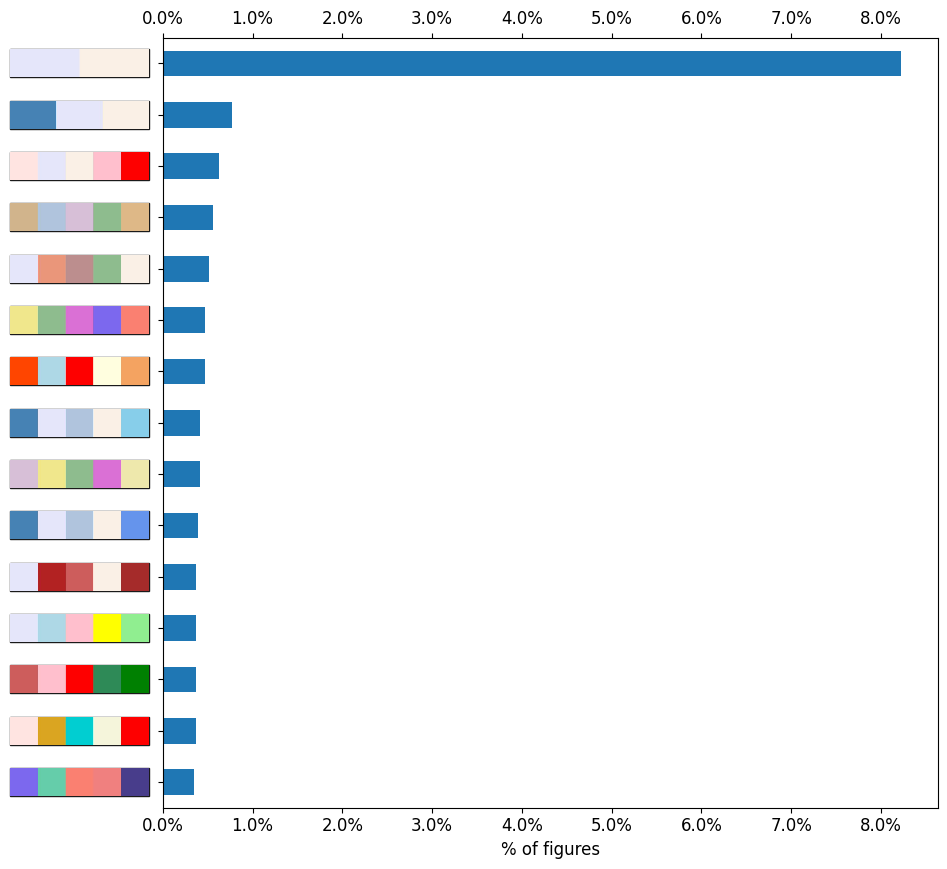

In [71]:
n_palettes = 15

palette_imgs = [create_palette(palette) for palette in palettes[:n_palettes]]

palette_imgs.reverse()
for i in range(n_palettes):
    palette_imgs[i].save(f"palettes/palette_{i}.jpg")

palette_df = properties_df["palette"].value_counts()
ax = palette_df.div(sum(palette_df)).head(n_palettes).sort_values(ascending=True).plot.barh(figsize=(10,10))

def get_img(path, zoom=0.2):
    img = mpimg.imread(path)
    return OffsetImage(img, zoom=zoom)

for i in range(n_palettes):
    y = ax.get_yticks()[i]
    img_box = AnnotationBbox(get_img(f"palettes/palette_{i}.jpg"), (0,y-0.27), frameon=True, xybox=(-60,10),
                            xycoords="data", boxcoords="offset points", pad=0, fontsize=15)
    ax.add_artist(img_box)

ax.set_yticklabels([])
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=True)
ax.set_xlabel("% of figures", fontsize=12)


### Visual density

In [72]:
white_thresh = 250 - 8

def get_non_white(colors):
    colors = ast.literal_eval(colors)[:30]
    white_frac = 0
    for color, frac in colors:
        r,g,b = webcolors.hex_to_rgb(f"#{color}")
        if r >= white_thresh and g >= white_thresh and b >= white_thresh:
            white_frac += frac
    return 1 - white_frac

properties_df["non-white"] = properties_df.apply(lambda row: get_non_white(row.colors), axis=1)

In [73]:
print("Average visual density (% non-white)", np.mean(properties_df["non-white"]))

Average visual density (% non-white) 0.24066808544848894


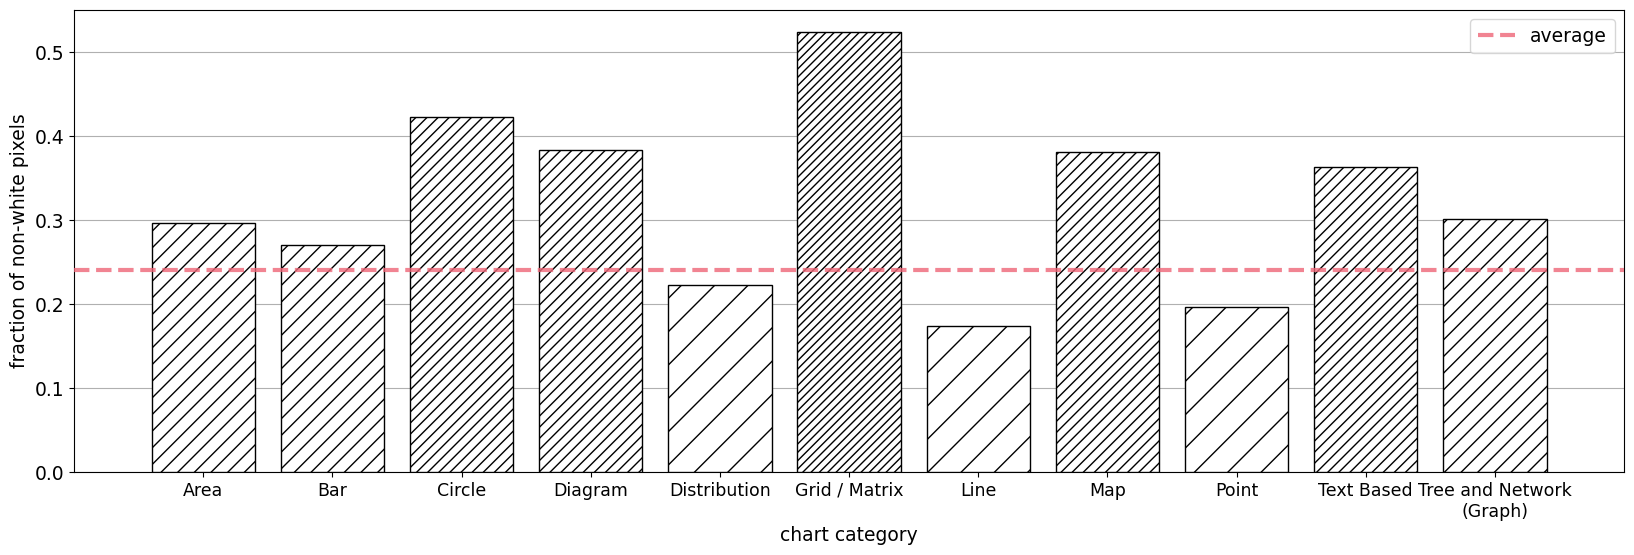

In [74]:
non_df_grouped = properties_df.groupby(["category"])["non-white"].mean()
min_hatch = min(non_df_grouped.values)

fig = plt.figure(figsize=(20,6))
for cat in non_df_grouped.index:
    if cat == "Tree and Network (Graph)":
        plt.bar("Tree and Network\n(Graph)", non_df_grouped[cat], hatch=round((non_df_grouped[cat]-min_hatch)/0.1 + 1)*"/", color="white", edgecolor="black", zorder=3)
    else:
        plt.bar(cat, non_df_grouped[cat], hatch=round((non_df_grouped[cat]-min_hatch)/0.1 + 1)*"/", color="white", edgecolor="black", zorder=3)
    
x = [-1] + list(range(properties_df["category"].nunique())) + [properties_df["category"].nunique()]
plt.plot(x, [np.mean(properties_df["non-white"])]*len(x), label="average", color=colors[1], linestyle="dashed", linewidth=3, zorder=4, alpha=0.8)
plt.margins(x=0)
plt.xticks(fontsize=12.5)
plt.yticks(fontsize=13.5)
plt.ylabel("fraction of non-white pixels", fontsize=13.5)
plt.xlabel("chart category", fontsize=13.5)
plt.grid(axis="y", zorder=0)
plt.legend(fontsize=13.5)
